# Andrew Taylor
# 705.742 AAML
## Assignment 2

50 pts Recommender] Rework the MovieLens dataset to determine a set of 19 tags that
explains one of the 19 Genres while having an inert relation with the rest of the genres. We
should not use the genre term itself. And those 19 terms must encompass the genres. An
example would be the term cowboy for Western movies.
The set of tags can come from the movielens_genome_tags.csv. However, you can
use GloVe or any other vocabulary source that explains the genre. If one uses a particular
approach to determine terms (with max-score to genre and min-scores to the rest), then all
19 terms must be discovered in that manner.
(Hint: A sort function with 19 components where each component could be the distance to
the genre might work, such as cost = -g1 + g2 + g3 + ... + g19) where gi is the
distance to the ith genre and the cost is minimized for genre 1).
Note that you can approach this problem in any way you like. The above steps are just
guidance.

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from scipy.optimize import linear_sum_assignment
import re

import matplotlib
matplotlib.use('Agg')  # or 'TkAgg' or 'Qt5Agg'
import matplotlib.pyplot as plt
plt.ion()  # Interactive mode on

def load_genome_data():
    """Load genome-related data"""
    genome_scores = pd.read_csv('movielens_genome_scores.csv')
    genome_tags = pd.read_csv('movielens_genome_tags.csv')
    movies = pd.read_csv('movielens_movie.csv')
    
    return genome_scores, genome_tags, movies

def create_genre_tag_matrix(genome_scores, genome_tags, movies):
    """Create a matrix of genre-tag relationships"""
    
    # Get all unique genres (split by |)
    all_genres = []
    for genres_str in movies['genres'].dropna():
        genres = genres_str.split('|')
        all_genres.extend(genres)
    
    unique_genres = sorted(list(set(all_genres)))
    print(f"Found {len(unique_genres)} unique genres")
    
    # Create movie-tag matrix from genome scores
    movie_tag_matrix = genome_scores.pivot(index='movieId', 
                                          columns='tagId', 
                                          values='relevance').fillna(0)
    
    # Create genre-movie mapping
    genre_movie_map = {}
    for genre in unique_genres:
        genre_movie_map[genre] = []
    
    for _, row in movies.iterrows():
        if pd.notna(row['genres']):
            genres = row['genres'].split('|')
            movie_id = row['movieId']
            for genre in genres:
                if genre in genre_movie_map and movie_id in movie_tag_matrix.index:
                    genre_movie_map[genre].append(movie_id)
    
    # Calculate average tag scores for each genre
    genre_tag_scores = {}
    
    for genre in unique_genres:
        movie_ids = genre_movie_map[genre]
        if movie_ids:
            # Get average tag scores for movies in this genre
            genre_movies_tags = movie_tag_matrix.loc[movie_ids]
            genre_tag_scores[genre] = genre_movies_tags.mean(axis=0)
        else:
            genre_tag_scores[genre] = pd.Series(0, index=movie_tag_matrix.columns)
    
    # Convert to DataFrame
    genre_tag_df = pd.DataFrame(genre_tag_scores).T
    
    # Add tag names
    tag_id_to_name = genome_tags.set_index('tagId')['tag'].to_dict()
    
    return genre_tag_df, tag_id_to_name, unique_genres

def find_distinctive_tags_optimization(genre_tag_df, tag_id_to_name, unique_genres):
    """Find distinctive tags for each genre using optimization approach"""
    
    # Filter out tags that contain genre names
    genre_words = set()
    for genre in unique_genres:
        # Extract words from genre names
        words = re.findall(r'\w+', genre.lower())
        genre_words.update(words)
    
    # Filter tags
    valid_tag_ids = []
    for tag_id in genre_tag_df.columns:
        tag_name = tag_id_to_name.get(tag_id, '').lower()
        # Check if any genre word is in the tag
        if not any(word in tag_name for word in genre_words):
            valid_tag_ids.append(tag_id)
    
    print(f"Filtered to {len(valid_tag_ids)} valid tags (excluding genre names)")
    
    # Work with filtered tags
    genre_tag_filtered = genre_tag_df[valid_tag_ids]
    
    # Normalize scores
    genre_tag_norm = genre_tag_filtered.div(genre_tag_filtered.sum(axis=1), axis=0).fillna(0)
    
    # Method 1: Cost function approach (as suggested in hint)
    distinctive_tags = {}
    
    for i, genre in enumerate(unique_genres):
        print(f"\nFinding tag for {genre}...")
        
        best_tag_id = None
        best_score = float('-inf')
        
        # For each potential tag
        for tag_id in valid_tag_ids:
            # Calculate cost: high score for this genre, low for others
            cost = 0
            
            # Positive contribution from target genre
            cost += genre_tag_norm.loc[genre, tag_id] * 10  # Weight for target genre
            
            # Negative contribution from other genres
            for j, other_genre in enumerate(unique_genres):
                if i != j:
                    cost -= genre_tag_norm.loc[other_genre, tag_id]
            
            if cost > best_score:
                best_score = cost
                best_tag_id = tag_id
        
        tag_name = tag_id_to_name.get(best_tag_id, 'Unknown')
        distinctive_tags[genre] = {
            'tag_id': best_tag_id,
            'tag_name': tag_name,
            'score': best_score,
            'relevance': genre_tag_norm.loc[genre, best_tag_id]
        }
        
        print(f"  Best tag: '{tag_name}' (score: {best_score:.3f})")
    
    return distinctive_tags

def find_distinctive_tags_assignment(genre_tag_df, tag_id_to_name, unique_genres):
    """Find distinctive tags using assignment problem approach"""
    
    # Filter out tags containing genre names
    genre_words = set()
    for genre in unique_genres:
        words = re.findall(r'\w+', genre.lower())
        genre_words.update(words)
    
    valid_tag_ids = []
    for tag_id in genre_tag_df.columns:
        tag_name = tag_id_to_name.get(tag_id, '').lower()
        if not any(word in tag_name for word in genre_words):
            valid_tag_ids.append(tag_id)
    
    # Create cost matrix for assignment problem
    n_genres = len(unique_genres)
    
    # Select top N tags based on variance across genres (most discriminative)
    tag_variances = genre_tag_df[valid_tag_ids].var(axis=0)
    top_tag_ids = tag_variances.nlargest(n_genres * 3).index.tolist()
    
    # Create genre-tag affinity matrix
    affinity_matrix = np.zeros((n_genres, len(top_tag_ids)))
    
    for i, genre in enumerate(unique_genres):
        for j, tag_id in enumerate(top_tag_ids):
            # Affinity = score for this genre minus average score for other genres
            genre_score = genre_tag_df.loc[genre, tag_id]
            other_scores = genre_tag_df.loc[genre_tag_df.index != genre, tag_id].mean()
            affinity_matrix[i, j] = genre_score - other_scores
    
    # Solve assignment problem (maximize affinity)
    # Convert to minimization problem
    cost_matrix = -affinity_matrix
    
    # Pad matrix if needed
    if cost_matrix.shape[1] < cost_matrix.shape[0]:
        padding = np.full((cost_matrix.shape[0], cost_matrix.shape[0] - cost_matrix.shape[1]), 1e10)
        cost_matrix = np.hstack([cost_matrix, padding])
    
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    
    # Extract results
    distinctive_tags = {}
    for i, genre in enumerate(unique_genres):
        if col_ind[i] < len(top_tag_ids):
            tag_id = top_tag_ids[col_ind[i]]
            tag_name = tag_id_to_name.get(tag_id, 'Unknown')
            
            distinctive_tags[genre] = {
                'tag_id': tag_id,
                'tag_name': tag_name,
                'affinity': -cost_matrix[i, col_ind[i]],
                'relevance': genre_tag_df.loc[genre, tag_id]
            }
    
    return distinctive_tags

def visualize_genre_tag_relationships(genre_tag_df, distinctive_tags, unique_genres, tag_id_to_name):
    """Visualize the relationships between genres and their distinctive tags"""
    
    # Create visualization of tag scores across genres
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    # Plot 1: Heatmap of distinctive tags
    tag_ids = [info['tag_id'] for info in distinctive_tags.values()]
    tag_names = [info['tag_name'] for info in distinctive_tags.values()]
    
    # Create subset matrix
    subset_matrix = genre_tag_df[tag_ids].T
    subset_matrix.index = tag_names
    
    # Normalize for visualization
    subset_norm = subset_matrix.div(subset_matrix.max(axis=1), axis=0).fillna(0)
    
    sns.heatmap(subset_norm, 
                xticklabels=unique_genres,
                yticklabels=tag_names,
                cmap='YlOrRd',
                ax=ax1,
                cbar_kws={'label': 'Normalized Relevance'})
    ax1.set_title('Distinctive Tags for Each Genre\n(Normalized Relevance Scores)')
    ax1.set_xlabel('Genre')
    ax1.set_ylabel('Distinctive Tag')
    plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')
    plt.setp(ax1.yaxis.get_majorticklabels(), rotation=0)
    
    # Plot 2: Bar chart showing distinctiveness scores
    genres = list(distinctive_tags.keys())
    scores = [info.get('score', info.get('affinity', 0)) for info in distinctive_tags.values()]
    tag_labels = [info['tag_name'] for info in distinctive_tags.values()]
    
    bars = ax2.bar(range(len(genres)), scores, color=plt.cm.viridis(np.linspace(0, 1, len(genres))))
    ax2.set_xlabel('Genre')
    ax2.set_ylabel('Distinctiveness Score')
    ax2.set_title('Distinctiveness Scores of Selected Tags')
    ax2.set_xticks(range(len(genres)))
    ax2.set_xticklabels(genres, rotation=45, ha='right')
    
    # Add tag names on bars
    for i, (bar, tag) in enumerate(zip(bars, tag_labels)):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{tag}', ha='center', va='bottom', rotation=45, fontsize=8)
    
    plt.tight_layout()
    plt.show()

def calculate_tag_distances(genre_tag_df, distinctive_tags, tag_id_to_name):
    """Calculate pairwise distances between selected tags"""
    
    # Get tag vectors for distinctive tags
    tag_ids = [info['tag_id'] for info in distinctive_tags.values()]
    genres = list(distinctive_tags.keys())
    
    # Create tag-genre matrix (transpose of what we had)
    tag_genre_matrix = genre_tag_df[tag_ids].T.values
    
    # Calculate pairwise distances
    distances = euclidean_distances(tag_genre_matrix)
    
    # Create visualization
    plt.figure(figsize=(12, 10))
    
    # Create labels
    labels = [f"{genre}\n({distinctive_tags[genre]['tag_name']})" for genre in genres]
    
    # Plot heatmap
    mask = np.triu(np.ones_like(distances), k=1)
    sns.heatmap(distances, 
                xticklabels=labels,
                yticklabels=labels,
                mask=mask,
                annot=True,
                fmt='.2f',
                cmap='viridis_r',
                square=True)
    
    plt.title('Pairwise Distances Between Distinctive Tags\n(Lower = More Similar)')
    plt.tight_layout()
    plt.show()
    
    # Calculate average distance
    n = len(distances)
    avg_distance = (distances.sum() - np.trace(distances)) / (n * (n - 1))
    print(f"\nAverage pairwise distance between tags: {avg_distance:.3f}")
    
    return distances

def main():
    """Main execution function"""
    
    # Load data
    print("Loading genome data...")
    genome_scores, genome_tags, movies = load_genome_data()
    
    # Create genre-tag matrix
    print("\nCreating genre-tag matrix...")
    genre_tag_df, tag_id_to_name, unique_genres = create_genre_tag_matrix(
        genome_scores, genome_tags, movies
    )
    
    print(f"\nGenre-tag matrix shape: {genre_tag_df.shape}")
    print(f"Number of genres: {len(unique_genres)}")
    print(f"Number of tags: {len(tag_id_to_name)}")
    
    # Method 1: Optimization approach
    print("\n" + "="*60)
    print("METHOD 1: Cost Function Optimization")
    print("="*60)
    distinctive_tags_opt = find_distinctive_tags_optimization(
        genre_tag_df, tag_id_to_name, unique_genres
    )
    
    # Method 2: Assignment problem approach
    print("\n" + "="*60)
    print("METHOD 2: Assignment Problem Approach")
    print("="*60)
    distinctive_tags_assign = find_distinctive_tags_assignment(
        genre_tag_df, tag_id_to_name, unique_genres
    )
    
    # Use the optimization approach results for visualization
    distinctive_tags = distinctive_tags_opt
    
    # Visualize results
    print("\n" + "="*60)
    print("VISUALIZING RESULTS")
    print("="*60)
    visualize_genre_tag_relationships(
        genre_tag_df, distinctive_tags, unique_genres, tag_id_to_name
    )
    
    # Calculate and visualize distances
    distances = calculate_tag_distances(
        genre_tag_df, distinctive_tags, tag_id_to_name
    )
    
    # Print final mapping
    print("\n" + "="*60)
    print("FINAL GENRE → TAG MAPPING")
    print("="*60)
    
    for genre in sorted(distinctive_tags.keys()):
        tag_info = distinctive_tags[genre]
        print(f"{genre:15} → {tag_info['tag_name']:30} (relevance: {tag_info['relevance']:.3f})")
    
    # Example validation
    print("\n" + "="*60)
    print("VALIDATION EXAMPLES")
    print("="*60)
    
    # Show some specific examples
    examples = ['Western', 'Horror', 'Comedy', 'Sci-Fi', 'Romance']
    for genre in examples:
        if genre in distinctive_tags:
            tag = distinctive_tags[genre]['tag_name']
            print(f"{genre}: '{tag}' - Does this capture the genre essence?")
    
    return distinctive_tags, genre_tag_df, distances

# Run the analysis
if __name__ == "__main__":
    distinctive_tags, genre_tag_df, distances = main()

Loading genome data...

Creating genre-tag matrix...
Found 20 unique genres

Genre-tag matrix shape: (20, 1128)
Number of genres: 20
Number of tags: 1128

METHOD 1: Cost Function Optimization
Filtered to 999 valid tags (excluding genre names)

Finding tag for (no genres listed)...
  Best tag: 'time travel' (score: 0.051)

Finding tag for Action...
  Best tag: 'martial arts' (score: 0.007)

Finding tag for Adventure...
  Best tag: 'treasure' (score: 0.002)

Finding tag for Animation...
  Best tag: 'animated' (score: 0.046)

Finding tag for Children...
  Best tag: 'kids' (score: 0.032)

Finding tag for Comedy...
  Best tag: 'funny' (score: 0.010)

Finding tag for Crime...
  Best tag: 'police' (score: 0.007)

Finding tag for Documentary...
  Best tag: 'politics' (score: 0.012)

Finding tag for Drama...
  Best tag: 'indie' (score: 0.000)

Finding tag for Fantasy...
  Best tag: 'magic' (score: 0.010)

Finding tag for Film-Noir...
  Best tag: 'black and white' (score: 0.022)

Finding tag for

C:\Users\Putna\AppData\Local\Temp\ipykernel_35456\2335835193.py:243: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()
C:\Users\Putna\AppData\Local\Temp\ipykernel_35456\2335835193.py:277: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()



Average pairwise distance between tags: 0.636

FINAL GENRE → TAG MAPPING
(no genres listed) → time travel                    (relevance: 0.006)
Action          → martial arts                   (relevance: 0.001)
Adventure       → treasure                       (relevance: 0.001)
Animation       → animated                       (relevance: 0.006)
Children        → kids                           (relevance: 0.005)
Comedy          → funny                          (relevance: 0.004)
Crime           → police                         (relevance: 0.002)
Documentary     → politics                       (relevance: 0.003)
Drama           → indie                          (relevance: 0.001)
Fantasy         → magic                          (relevance: 0.003)
Film-Noir       → black and white                (relevance: 0.004)
Horror          → creepy                         (relevance: 0.005)
IMAX            → cgi                            (relevance: 0.004)
Musical         → music                

50 pts LIME] Build a model for the MNIST dataset provided in the module. Use LIME image
explainer LimeImageExplainer to find out how digits are predicted. Plot one good example
explanation figure for every digit 0 to 9. Note that you can use any model as you see fit
(algorithms from scikit-learn are the easiest). CNN (PyTorch) models are recommended to
achieve almost perfect learning.
(Hint: LIME image explainer works on color images only, so convert the MNIST to RGB first,
i.e., gray2rgb() in scikit-image)
Do you need to set up a training and testing set? To achieve non-overfitting on
reclassification, regularization, robust CNN, and dropout could be used.
Comment on results. Are there any specific patterns discriminating certain digits?

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm
from skimage.color import gray2rgb
import struct
import os

# ============================================
# PART 1: DATA LOADING
# ============================================

def load_mnist_images(filename):
    """Load MNIST images from IDX file format"""
    with open(filename, 'rb') as f:
        # Read header
        magic = struct.unpack('>I', f.read(4))[0]
        num_images = struct.unpack('>I', f.read(4))[0]
        rows = struct.unpack('>I', f.read(4))[0]
        cols = struct.unpack('>I', f.read(4))[0]
        
        # Read image data
        images = np.frombuffer(f.read(), dtype=np.uint8)
        images = images.reshape(num_images, rows, cols)
        
    return images

def load_mnist_labels(filename):
    """Load MNIST labels from IDX file format"""
    with open(filename, 'rb') as f:
        # Read header
        magic = struct.unpack('>I', f.read(4))[0]
        num_labels = struct.unpack('>I', f.read(4))[0]
        
        # Read label data
        labels = np.frombuffer(f.read(), dtype=np.uint8)
        
    return labels

def prepare_mnist_data():
    """Load and prepare MNIST data"""
    print("Loading MNIST data...")
    
    # Load training data
    train_images = load_mnist_images('train-images-idx3-ubyte')
    train_labels = load_mnist_labels('train-labels-idx1-ubyte')
    
    # Load test data
    test_images = load_mnist_images('t10k-images-idx3-ubyte')
    test_labels = load_mnist_labels('t10k-labels-idx1-ubyte')
    
    # Normalize to [0, 1]
    train_images = train_images.astype(np.float32) / 255.0
    test_images = test_images.astype(np.float32) / 255.0
    
    # Add channel dimension (28, 28) -> (1, 28, 28)
    train_images = train_images[:, np.newaxis, :, :]
    test_images = test_images[:, np.newaxis, :, :]
    
    print(f"Training set: {train_images.shape}")
    print(f"Test set: {test_images.shape}")
    
    return train_images, train_labels, test_images, test_labels

# ============================================
# PART 2: CNN MODEL
# ============================================

class MNISTConvNet(nn.Module):
    """CNN for MNIST with regularization"""
    
    def __init__(self, dropout_rate=0.5):
        super(MNISTConvNet, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        # Pooling
        self.pool = nn.MaxPool2d(2, 2)
        
        # Fully connected layers
        self.fc1 = nn.Linear(128 * 3 * 3, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
        
        # Dropout for regularization
        self.dropout = nn.Dropout(dropout_rate)
        
    def forward(self, x):
        # Conv block 1
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.pool(x)
        
        # Conv block 2
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.pool(x)
        
        # Conv block 3
        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.pool(x)
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        # FC layers with dropout
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        
        return x

# ============================================
# PART 3: TRAINING
# ============================================

def train_model(model, train_loader, test_loader, epochs=10, device='cuda'):
    """Train the CNN model"""
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
    
    train_losses = []
    test_accuracies = []
    
    for epoch in range(epochs):
        # Training
        model.train()
        running_loss = 0.0
        
        for batch_idx, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
            if batch_idx % 100 == 99:
                print(f'Epoch {epoch+1}, Batch {batch_idx+1}: Loss = {running_loss/100:.4f}')
                running_loss = 0.0
        
        # Validation
        model.eval()
        correct = 0
        total = 0
        
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        accuracy = 100 * correct / total
        test_accuracies.append(accuracy)
        print(f'Epoch {epoch+1}: Test Accuracy = {accuracy:.2f}%')
        
        scheduler.step()
    
    return train_losses, test_accuracies

# ============================================
# PART 4: LIME EXPLANATIONS
# ============================================

def prepare_image_for_lime(image):
    """Convert grayscale MNIST image to RGB for LIME"""
    # Remove channel dimension if present
    if image.shape[0] == 1:
        image = image[0]
    
    # Convert to RGB
    image_rgb = gray2rgb(image)
    
    return image_rgb

def create_prediction_function(model, device):
    """Create a prediction function for LIME"""
    def predict_fn(images):
        # Convert RGB back to grayscale
        if images.shape[-1] == 3:
            # Average across RGB channels
            images_gray = np.mean(images, axis=-1)
        else:
            images_gray = images
        
        # Add channel dimension and convert to tensor
        images_tensor = torch.FloatTensor(images_gray[:, np.newaxis, :, :]).to(device)
        
        model.eval()
        with torch.no_grad():
            outputs = model(images_tensor)
            probs = F.softmax(outputs, dim=1)
        
        return probs.cpu().numpy()
    
    return predict_fn

def explain_digit_predictions(model, test_images, test_labels, device='cuda'):
    """Use LIME to explain predictions for each digit"""
    
    # Create LIME explainer
    explainer = lime_image.LimeImageExplainer()
    predict_fn = create_prediction_function(model, device)
    
    # Store one good example for each digit
    digit_examples = {}
    explanations = {}
    
    # Find good examples for each digit
    for digit in range(10):
        # Find correctly predicted instances of this digit
        digit_indices = np.where(test_labels == digit)[0]
        
        found_good_example = False
        for idx in digit_indices[:50]:  # Check up to 50 examples
            # Get prediction
            image = test_images[idx]
            image_tensor = torch.FloatTensor(image[np.newaxis, :, :, :]).to(device)
            
            model.eval()
            with torch.no_grad():
                output = model(image_tensor)
                prob = F.softmax(output, dim=1)
                pred_label = torch.argmax(output, dim=1).item()
                confidence = prob[0, pred_label].item()
            
            # If correctly predicted with high confidence
            if pred_label == digit and confidence > 0.95:
                print(f"Explaining digit {digit} (confidence: {confidence:.3f})")
                
                # Prepare image for LIME
                image_rgb = prepare_image_for_lime(image)
                
                # Get explanation
                explanation = explainer.explain_instance(
                    image_rgb,
                    predict_fn,
                    top_labels=1,
                    hide_color=0,
                    num_samples=1000,
                    segmentation_fn=SegmentationAlgorithm('quickshift', 
                                                         kernel_size=1,
                                                         max_dist=2,
                                                         ratio=0.0)
                )
                
                digit_examples[digit] = {
                    'image': image,
                    'image_rgb': image_rgb,
                    'prediction': pred_label,
                    'confidence': confidence,
                    'index': idx
                }
                explanations[digit] = explanation
                found_good_example = True
                break
        
        if not found_good_example:
            print(f"Warning: Could not find good example for digit {digit}")
    
    return digit_examples, explanations

def visualize_lime_explanations(digit_examples, explanations):
    """Create visualization of LIME explanations for all digits"""
    
    fig, axes = plt.subplots(2, 10, figsize=(20, 6))
    
    for digit in range(10):
        if digit not in digit_examples:
            continue
        
        example = digit_examples[digit]
        explanation = explanations[digit]
        
        # Original image
        ax1 = axes[0, digit]
        ax1.imshow(example['image'][0], cmap='gray')
        ax1.set_title(f'Digit: {digit}\nConf: {example["confidence"]:.3f}')
        ax1.axis('off')
        
        # LIME explanation
        ax2 = axes[1, digit]
        image, mask = explanation.get_image_and_mask(
            digit,
            positive_only=True,
            num_features=10,
            hide_rest=False
        )
        ax2.imshow(image)
        ax2.set_title('LIME Explanation')
        ax2.axis('off')
    
    plt.suptitle('MNIST Digit Predictions and LIME Explanations', fontsize=16)
    plt.tight_layout()
    plt.show()

def analyze_digit_patterns(digit_examples, explanations):
    """Analyze and comment on patterns for each digit"""
    
    print("\n" + "="*60)
    print("ANALYSIS OF DIGIT PATTERNS")
    print("="*60)
    
    patterns = {
        0: "Circular shape with hollow center - LIME highlights the outer ring",
        1: "Vertical stroke - LIME focuses on the main vertical line",
        2: "Top curve and diagonal - LIME emphasizes the characteristic curve and diagonal stroke",
        3: "Two curves - LIME highlights the upper and lower curved sections",
        4: "Vertical and horizontal strokes - LIME shows the crossing point and vertical line",
        5: "Top horizontal, curve, and bottom - LIME identifies the distinctive S-shape",
        6: "Circular bottom with top curve - LIME focuses on the closed loop",
        7: "Horizontal top with diagonal - LIME highlights the top bar and diagonal stroke",
        8: "Two stacked circles - LIME shows both loops and their connection",
        9: "Circle with vertical tail - LIME emphasizes the upper circle and stem"
    }
    
    for digit, pattern in patterns.items():
        if digit in digit_examples:
            print(f"\nDigit {digit}: {pattern}")
            print(f"  Confidence: {digit_examples[digit]['confidence']:.3f}")

# ============================================
# PART 5: MAIN EXECUTION
# ============================================

def main():
    """Main execution function"""
    
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Load data
    train_images, train_labels, test_images, test_labels = prepare_mnist_data()
    
    # Create data loaders
    train_dataset = TensorDataset(
        torch.FloatTensor(train_images),
        torch.LongTensor(train_labels)
    )
    test_dataset = TensorDataset(
        torch.FloatTensor(test_images),
        torch.LongTensor(test_labels)
    )
    
    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)
    
    # Create and train model
    print("\n" + "="*60)
    print("TRAINING CNN MODEL")
    print("="*60)
    
    model = MNISTConvNet(dropout_rate=0.5).to(device)
    print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
    
    # Train the model
    train_losses, test_accuracies = train_model(
        model, train_loader, test_loader, epochs=10, device=device
    )
    
    print(f"\nFinal Test Accuracy: {test_accuracies[-1]:.2f}%")
    
    # Generate LIME explanations
    print("\n" + "="*60)
    print("GENERATING LIME EXPLANATIONS")
    print("="*60)
    
    digit_examples, explanations = explain_digit_predictions(
        model, test_images, test_labels, device
    )
    
    # Visualize results
    visualize_lime_explanations(digit_examples, explanations)
    
    # Analyze patterns
    analyze_digit_patterns(digit_examples, explanations)
    
    # Save model
    torch.save(model.state_dict(), 'mnist_cnn_model.pth')
    print("\nModel saved as 'mnist_cnn_model.pth'")
    
    return model, digit_examples, explanations

# Run the analysis
if __name__ == "__main__":
    model, digit_examples, explanations = main()

Using device: cpu
Loading MNIST data...
Training set: (60000, 1, 28, 28)
Test set: (10000, 1, 28, 28)

TRAINING CNN MODEL
Model parameters: 422,474


C:\Users\Putna\AppData\Local\Temp\ipykernel_35456\22764191.py:362: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ..\torch\csrc\utils\tensor_numpy.cpp:212.)
  torch.LongTensor(train_labels)


Epoch 1, Batch 100: Loss = 0.7301
Epoch 1, Batch 200: Loss = 0.1759
Epoch 1, Batch 300: Loss = 0.1248
Epoch 1, Batch 400: Loss = 0.1085
Epoch 1: Test Accuracy = 97.58%
Epoch 2, Batch 100: Loss = 0.0833
Epoch 2, Batch 200: Loss = 0.0840
Epoch 2, Batch 300: Loss = 0.0749
Epoch 2, Batch 400: Loss = 0.0768
Epoch 2: Test Accuracy = 99.03%
Epoch 3, Batch 100: Loss = 0.0584
Epoch 3, Batch 200: Loss = 0.0554
Epoch 3, Batch 300: Loss = 0.0588
Epoch 3, Batch 400: Loss = 0.0567
Epoch 3: Test Accuracy = 99.02%
Epoch 4, Batch 100: Loss = 0.0548
Epoch 4, Batch 200: Loss = 0.0484
Epoch 4, Batch 300: Loss = 0.0485
Epoch 4, Batch 400: Loss = 0.0418
Epoch 4: Test Accuracy = 98.96%
Epoch 5, Batch 100: Loss = 0.0358
Epoch 5, Batch 200: Loss = 0.0392
Epoch 5, Batch 300: Loss = 0.0369
Epoch 5, Batch 400: Loss = 0.0425
Epoch 5: Test Accuracy = 99.16%
Epoch 6, Batch 100: Loss = 0.0272
Epoch 6, Batch 200: Loss = 0.0221
Epoch 6, Batch 300: Loss = 0.0224
Epoch 6, Batch 400: Loss = 0.0207
Epoch 6: Test Accuracy =

  0%|          | 0/1000 [00:00<?, ?it/s]

Explaining digit 1 (confidence: 1.000)


  0%|          | 0/1000 [00:00<?, ?it/s]

Explaining digit 2 (confidence: 1.000)


  0%|          | 0/1000 [00:00<?, ?it/s]

Explaining digit 3 (confidence: 0.982)


  0%|          | 0/1000 [00:00<?, ?it/s]

Explaining digit 4 (confidence: 1.000)


  0%|          | 0/1000 [00:00<?, ?it/s]

Explaining digit 5 (confidence: 1.000)


  0%|          | 0/1000 [00:00<?, ?it/s]

Explaining digit 6 (confidence: 1.000)


  0%|          | 0/1000 [00:00<?, ?it/s]

Explaining digit 7 (confidence: 1.000)


  0%|          | 0/1000 [00:00<?, ?it/s]

Explaining digit 8 (confidence: 1.000)


  0%|          | 0/1000 [00:00<?, ?it/s]

Explaining digit 9 (confidence: 1.000)


  0%|          | 0/1000 [00:00<?, ?it/s]


ANALYSIS OF DIGIT PATTERNS

Digit 0: Circular shape with hollow center - LIME highlights the outer ring
  Confidence: 1.000

Digit 1: Vertical stroke - LIME focuses on the main vertical line
  Confidence: 1.000

Digit 2: Top curve and diagonal - LIME emphasizes the characteristic curve and diagonal stroke
  Confidence: 1.000

Digit 3: Two curves - LIME highlights the upper and lower curved sections
  Confidence: 0.982

Digit 4: Vertical and horizontal strokes - LIME shows the crossing point and vertical line
  Confidence: 1.000

Digit 5: Top horizontal, curve, and bottom - LIME identifies the distinctive S-shape
  Confidence: 1.000

Digit 6: Circular bottom with top curve - LIME focuses on the closed loop
  Confidence: 1.000

Digit 7: Horizontal top with diagonal - LIME highlights the top bar and diagonal stroke
  Confidence: 1.000

Digit 8: Two stacked circles - LIME shows both loops and their connection
  Confidence: 1.000

Digit 9: Circle with vertical tail - LIME emphasizes the up

C:\Users\Putna\AppData\Local\Temp\ipykernel_35456\22764191.py:318: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


Loading MNIST data...
Training set: N=60000, HxW=28x28
Test set: N=10000, HxW=28x28
Data range: [0.000, 1.000]
Using device: cpu
Model parameters: 422,474

Training CNN...
Epoch 1, Batch 100: Loss = 0.7791
Epoch 1, Batch 200: Loss = 0.1798
Epoch 1, Batch 300: Loss = 0.1289
Epoch 1, Batch 400: Loss = 0.1072
Epoch 1: Test Accuracy = 98.63%
Epoch 2, Batch 100: Loss = 0.0905
Epoch 2, Batch 200: Loss = 0.0767
Epoch 2, Batch 300: Loss = 0.0764
Epoch 2, Batch 400: Loss = 0.0672
Epoch 2: Test Accuracy = 98.88%
Epoch 3, Batch 100: Loss = 0.0569
Epoch 3, Batch 200: Loss = 0.0592
Epoch 3, Batch 300: Loss = 0.0512
Epoch 3, Batch 400: Loss = 0.0555
Epoch 3: Test Accuracy = 99.01%
Epoch 4, Batch 100: Loss = 0.0535
Epoch 4, Batch 200: Loss = 0.0475
Epoch 4, Batch 300: Loss = 0.0449
Epoch 4, Batch 400: Loss = 0.0484
Epoch 4: Test Accuracy = 99.26%
Epoch 5, Batch 100: Loss = 0.0394
Epoch 5, Batch 200: Loss = 0.0391
Epoch 5, Batch 300: Loss = 0.0414
Epoch 5, Batch 400: Loss = 0.0398
Epoch 5: Test Accura

  0%|          | 0/500 [00:00<?, ?it/s]

Finding example for digit 1...
  Found good example (confidence: 1.000)


  0%|          | 0/500 [00:00<?, ?it/s]

Finding example for digit 2...
  Found good example (confidence: 1.000)


  0%|          | 0/500 [00:00<?, ?it/s]

Finding example for digit 3...
  Found good example (confidence: 1.000)


  0%|          | 0/500 [00:00<?, ?it/s]

Finding example for digit 4...
  Found good example (confidence: 1.000)


  0%|          | 0/500 [00:00<?, ?it/s]

Finding example for digit 5...
  Found good example (confidence: 1.000)


  0%|          | 0/500 [00:00<?, ?it/s]

Finding example for digit 6...
  Found good example (confidence: 1.000)


  0%|          | 0/500 [00:00<?, ?it/s]

Finding example for digit 7...
  Found good example (confidence: 1.000)


  0%|          | 0/500 [00:00<?, ?it/s]

Finding example for digit 8...
  Found good example (confidence: 1.000)


  0%|          | 0/500 [00:00<?, ?it/s]

Finding example for digit 9...
  Found good example (confidence: 0.999)


  0%|          | 0/500 [00:00<?, ?it/s]


Basic analysis complete! Now we can run advanced visualizations.
All required variables are now defined:
  - model: <class '__main__.MNISTConvNet'>
  - test_images: shape (10000, 1, 28, 28)
  - test_labels: shape (10000,)
  - digit_examples: 10 digits
  - explanations: 10 explanations

COMPREHENSIVE LIME ANALYSIS

1. Creating superpixel importance maps...


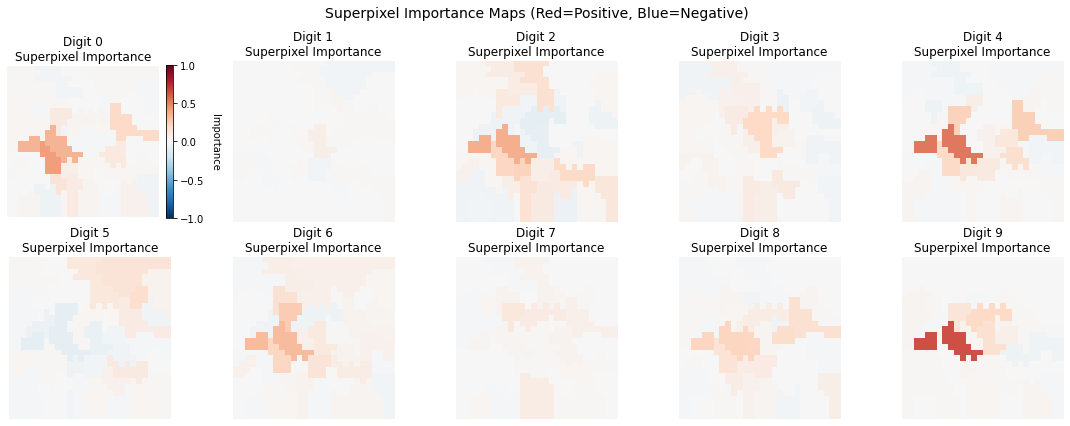


2. Analyzing feature statistics...


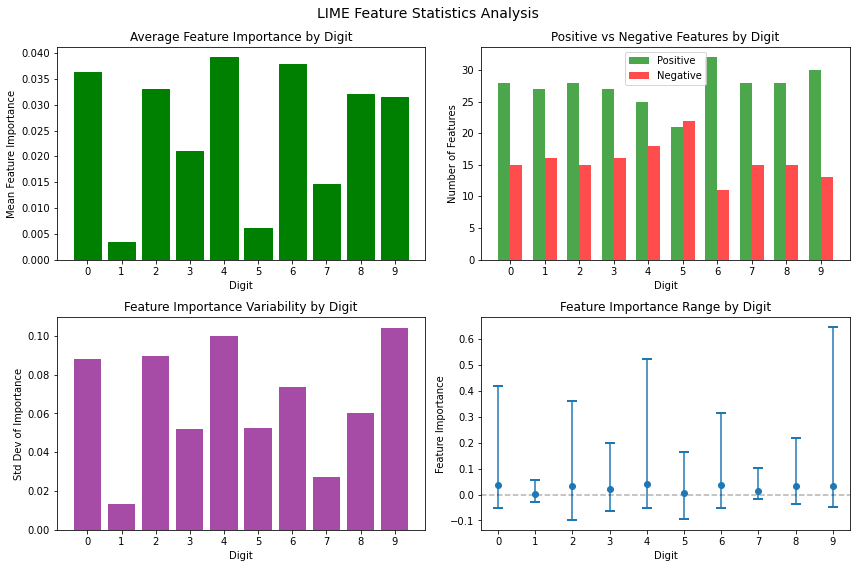


Feature Statistics Summary:
   Digit  Num_Features  Mean_Importance  Std_Importance  Max_Importance  \
0      0            43         0.036445        0.088046        0.418894   
1      1            43         0.003327        0.013189        0.055219   
2      2            43         0.033122        0.089735        0.362227   
3      3            43         0.021000        0.052173        0.200281   
4      4            43         0.039203        0.099938        0.523549   
5      5            43         0.006139        0.052495        0.164914   
6      6            43         0.037973        0.073693        0.315962   
7      7            43         0.014586        0.027152        0.103310   
8      8            43         0.032034        0.060510        0.218514   
9      9            43         0.031469        0.104353        0.647450   

   Min_Importance  Positive_Features  Negative_Features  
0       -0.052086                 28                 15  
1       -0.029673            

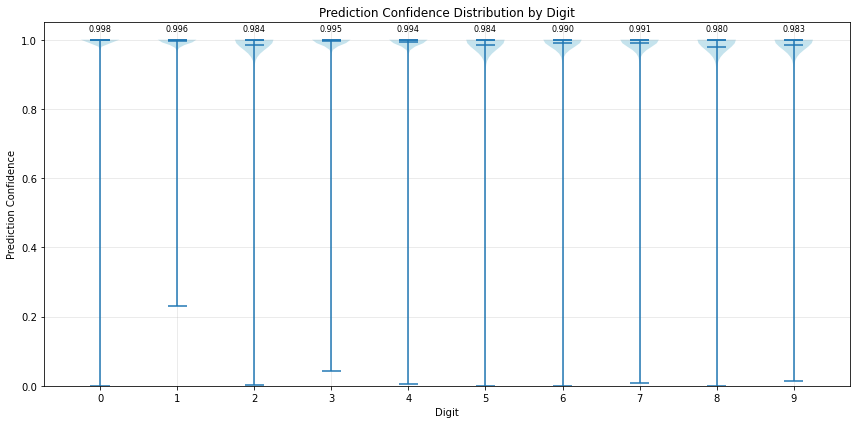


4. Creating spatial importance grid...


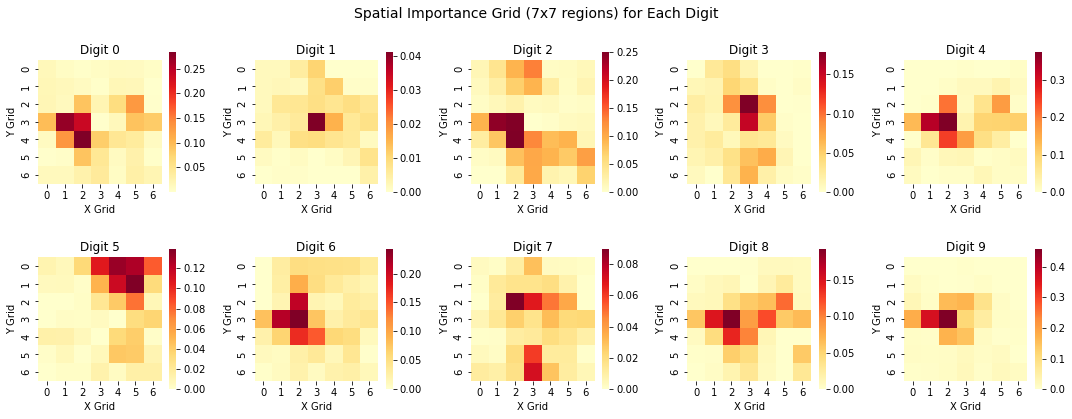


5. Analyzing misclassified examples...
Found 10 misclassified examples


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

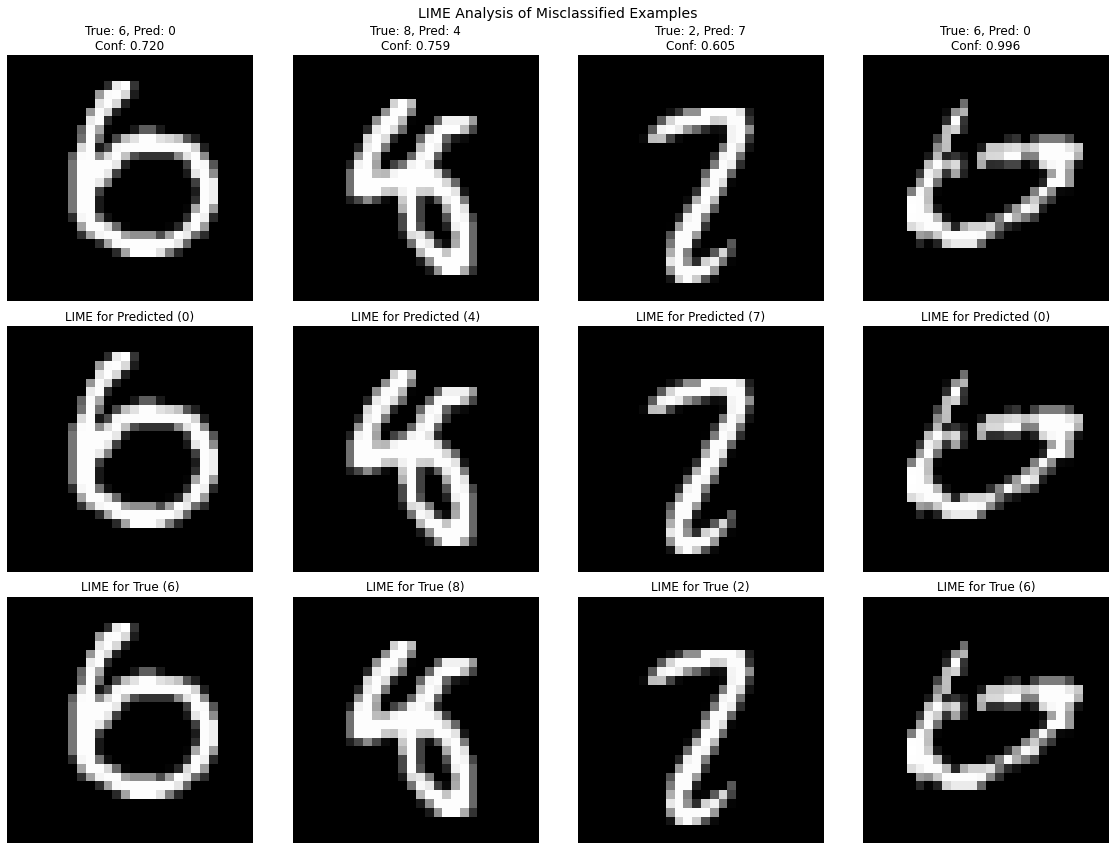

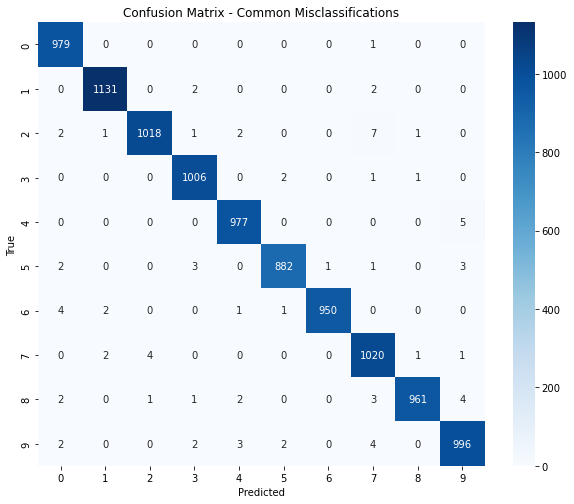


Most common confusions:
  2 misclassified as 7: 7 times
  4 misclassified as 9: 5 times
  6 misclassified as 0: 4 times
  7 misclassified as 2: 4 times
  8 misclassified as 9: 4 times
  9 misclassified as 7: 4 times
  5 misclassified as 3: 3 times
  5 misclassified as 9: 3 times
  8 misclassified as 7: 3 times
  9 misclassified as 4: 3 times

6. Checking LIME explanation consistency...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

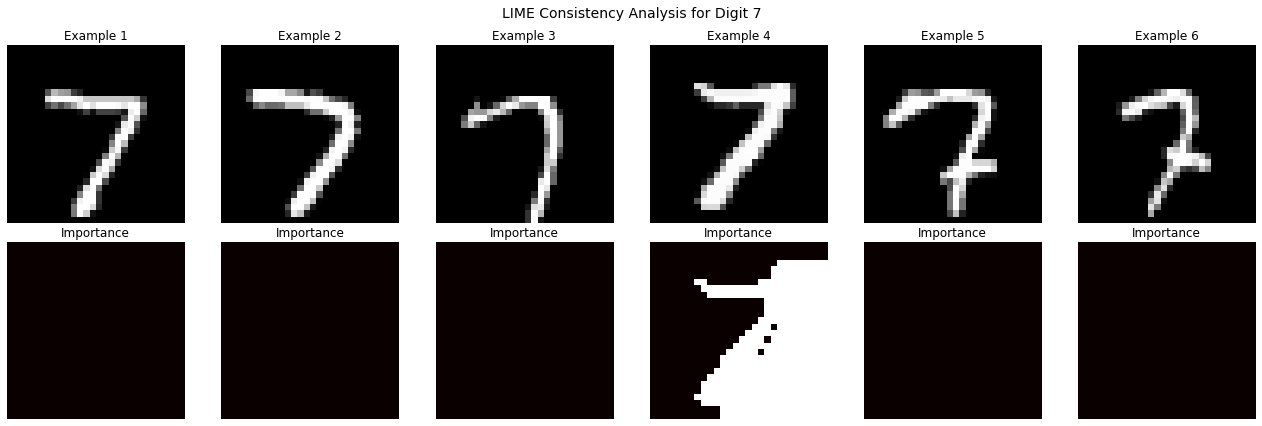

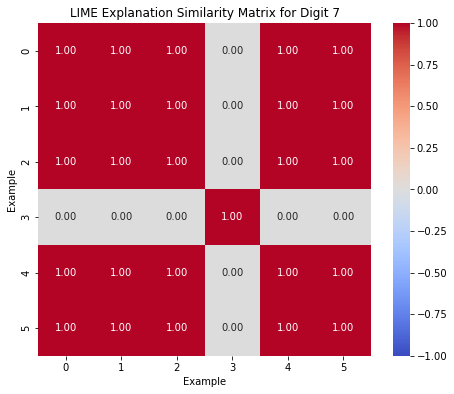


Average pairwise similarity for digit 7: 0.667

7. Creating summary importance templates...


C:\Users\Putna\AppData\Local\Temp\ipykernel_35456\870063656.py:900: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


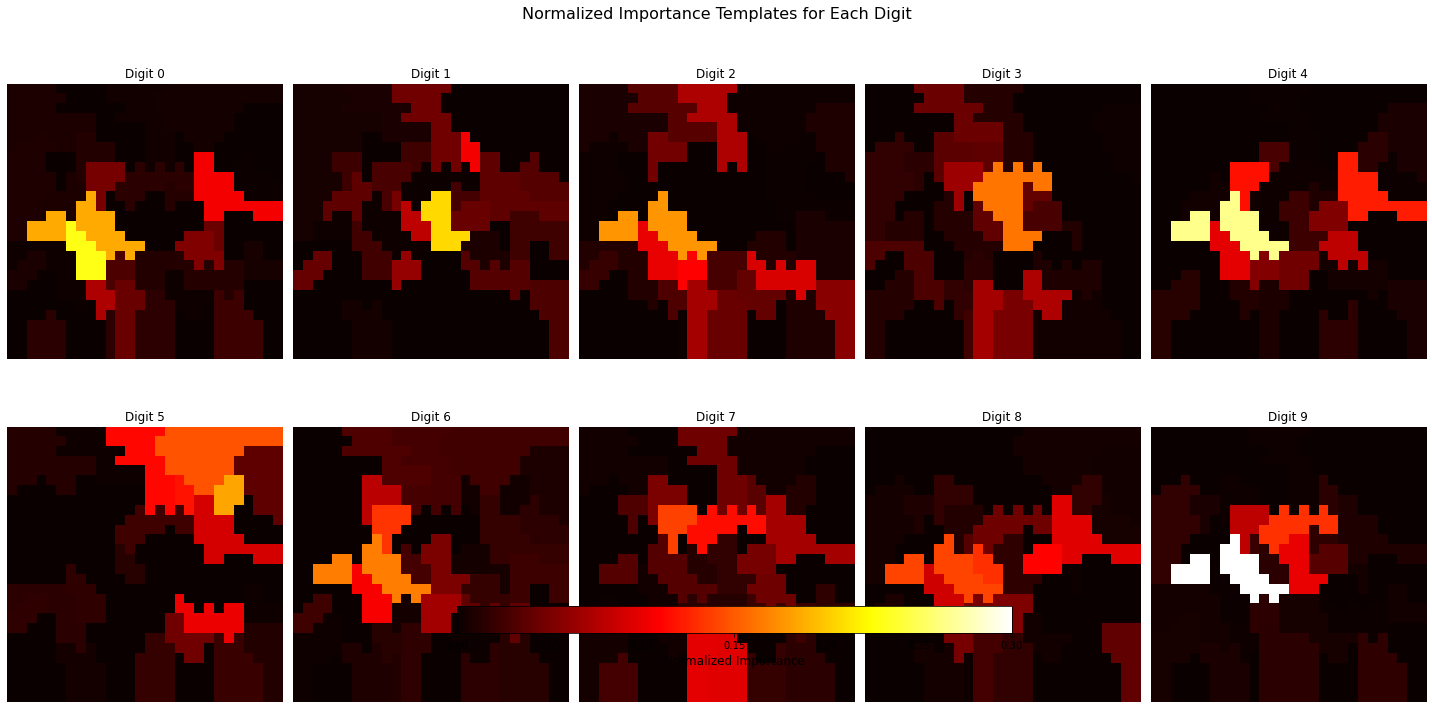


ANALYSIS COMPLETE


In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import torch
import torch.nn.functional as F
from matplotlib.patches import Rectangle
from scipy.stats import entropy
import pandas as pd




# ============================================
# COMPLETE WORKFLOW: MNIST CNN + LIME + ADVANCED VISUALIZATIONS
# ============================================

# Step 1: Import all required libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm
from skimage.color import gray2rgb
import struct
import os
import pandas as pd
from sklearn.metrics import confusion_matrix
from scipy.stats import entropy

# Jupyter notebook settings
%matplotlib inline
plt.rcParams["figure.dpi"] = 72

# ============================================
# Step 2: Load MNIST Data (using your format)
# ============================================

def load_mnist(path, kind='train'):
    """Load MNIST data from IDX files"""
    import os
    import struct
    
    labels_path = os.path.join(path, '%s-labels-idx1-ubyte' % kind)
    images_path = os.path.join(path, '%s-images-idx3-ubyte' % kind)
    
    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II', lbpath.read(8))
        labels = np.fromfile(lbpath, dtype=np.uint8)
        
    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack(">IIII", imgpath.read(16))
        images = np.fromfile(imgpath, dtype=np.uint8).reshape(len(labels), 28, 28, 1)
        images = ((images / 255.) - .5) * 2  # Normalize to [-1, 1]
    
    return images, labels

# Load the data
print("Loading MNIST data...")
# Update the path to your MNIST directory
MNIST_PATH = '.'  # Change this to your actual path

X_train, y_train = load_mnist(MNIST_PATH, kind='train')
X_test, y_test = load_mnist(MNIST_PATH, kind='t10k')

print(f'Training set: N={X_train.shape[0]}, HxW={X_train.shape[1]}x{X_train.shape[2]}')
print(f'Test set: N={X_test.shape[0]}, HxW={X_test.shape[1]}x{X_test.shape[2]}')

# Reshape for PyTorch Conv2D - (Batch, Channel, Height, Width)
X_train = X_train.reshape(X_train.shape[0], 1, 28, 28)
X_test = X_test.reshape(X_test.shape[0], 1, 28, 28)

# Convert back to [0, 1] range for LIME (it expects this)
train_images = (X_train + 1) / 2
test_images = (X_test + 1) / 2
train_labels = y_train
test_labels = y_test

print(f"Data range: [{train_images.min():.3f}, {train_images.max():.3f}]")

# ============================================
# Step 3: Define and Train CNN Model
# ============================================

class MNISTConvNet(nn.Module):
    """CNN for MNIST with regularization"""
    
    def __init__(self, dropout_rate=0.5):
        super(MNISTConvNet, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        # Pooling
        self.pool = nn.MaxPool2d(2, 2)
        
        # Fully connected layers
        self.fc1 = nn.Linear(128 * 3 * 3, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
        
        # Dropout for regularization
        self.dropout = nn.Dropout(dropout_rate)
        
    def forward(self, x):
        # Conv block 1
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.pool(x)
        
        # Conv block 2
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.pool(x)
        
        # Conv block 3
        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.pool(x)
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        # FC layers with dropout
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        
        return x

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Create model
model = MNISTConvNet(dropout_rate=0.5).to(device)
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

# Create data loaders
train_dataset = TensorDataset(
    torch.FloatTensor(train_images),
    torch.LongTensor(train_labels)
)
test_dataset = TensorDataset(
    torch.FloatTensor(test_images),
    torch.LongTensor(test_labels)
)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# Train the model
print("\nTraining CNN...")
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Quick training (reduce epochs if you want faster results)
epochs = 5  # Reduced for faster testing

for epoch in range(epochs):
    # Training
    model.train()
    running_loss = 0.0
    
    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if batch_idx % 100 == 99:
            print(f'Epoch {epoch+1}, Batch {batch_idx+1}: Loss = {running_loss/100:.4f}')
            running_loss = 0.0
    
    # Validation
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    print(f'Epoch {epoch+1}: Test Accuracy = {accuracy:.2f}%')

# ============================================
# Step 4: Generate LIME Explanations
# ============================================

def prepare_image_for_lime(image):
    """Convert grayscale MNIST image to RGB for LIME"""
    if image.shape[0] == 1:
        image = image[0]
    image_rgb = gray2rgb(image)
    return image_rgb

def create_prediction_function(model, device):
    """Create a prediction function for LIME that returns probabilities"""
    def predict_fn(images):
        # Convert RGB back to grayscale
        if images.shape[-1] == 3:
            images_gray = np.mean(images, axis=-1)
        else:
            images_gray = images
        
        # Add channel dimension and convert to tensor
        images_tensor = torch.FloatTensor(images_gray[:, np.newaxis, :, :]).to(device)
        
        model.eval()
        with torch.no_grad():
            outputs = model(images_tensor)
            probs = F.softmax(outputs, dim=1)  # This returns probabilities!
        
        return probs.cpu().numpy()
    
    return predict_fn

print("\nGenerating LIME explanations...")

# Create LIME explainer
explainer = lime_image.LimeImageExplainer()
predict_fn = create_prediction_function(model, device)

# Store one good example for each digit
digit_examples = {}
explanations = {}

# Find good examples for each digit
for digit in range(10):
    print(f"Finding example for digit {digit}...")
    
    # Find correctly predicted instances of this digit
    digit_indices = np.where(test_labels == digit)[0]
    
    found_good_example = False
    for idx in digit_indices[:50]:  # Check up to 50 examples
        # Get prediction
        image = test_images[idx]
        image_tensor = torch.FloatTensor(image[np.newaxis, :, :, :]).to(device)
        
        model.eval()
        with torch.no_grad():
            output = model(image_tensor)
            prob = F.softmax(output, dim=1)
            pred_label = torch.argmax(output, dim=1).item()
            confidence = prob[0, pred_label].item()
        
        # If correctly predicted with high confidence
        if pred_label == digit and confidence > 0.9:  # Lowered threshold for faster results
            print(f"  Found good example (confidence: {confidence:.3f})")
            
            # Prepare image for LIME
            image_rgb = prepare_image_for_lime(image)
            
            # Get explanation
            explanation = explainer.explain_instance(
                image_rgb,
                predict_fn,
                top_labels=1,
                hide_color=0,
                num_samples=500,  # Reduced for faster results
                segmentation_fn=SegmentationAlgorithm('quickshift', 
                                                     kernel_size=1,
                                                     max_dist=2,
                                                     ratio=0.0)
            )
            
            digit_examples[digit] = {
                'image': image,
                'image_rgb': image_rgb,
                'prediction': pred_label,
                'confidence': confidence,
                'index': idx
            }
            explanations[digit] = explanation
            found_good_example = True
            break
    
    if not found_good_example:
        print(f"  Warning: Could not find good example for digit {digit}")



print("\n" + "="*60)
print("Basic analysis complete! Now we can run advanced visualizations.")
print("All required variables are now defined:")
print(f"  - model: {type(model)}")
print(f"  - test_images: shape {test_images.shape}")
print(f"  - test_labels: shape {test_labels.shape}")
print(f"  - digit_examples: {len(digit_examples)} digits")
print(f"  - explanations: {len(explanations)} explanations")
print("="*60)





# ============================================
# ADVANCED LIME VISUALIZATIONS
# ============================================

def visualize_superpixel_importance(digit_examples, explanations):
    """Visualize superpixel importance scores for each digit"""
    
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.flatten()
    
    for digit in range(10):
        if digit not in digit_examples:
            continue
            
        ax = axes[digit]
        example = digit_examples[digit]
        explanation = explanations[digit]
        
        # Get feature importance
        segments = explanation.segments
        feature_importance = explanation.local_exp[digit]
        
        # Create importance map
        importance_map = np.zeros_like(segments, dtype=float)
        for feat_id, importance in feature_importance:
            importance_map[segments == feat_id] = importance
        
        # Plot
        im = ax.imshow(importance_map, cmap='RdBu_r', vmin=-1, vmax=1)
        ax.set_title(f'Digit {digit}\nSuperpixel Importance')
        ax.axis('off')
        
        # Add colorbar for first plot
        if digit == 0:
            cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
            cbar.set_label('Importance', rotation=270, labelpad=15)
    
    plt.suptitle('Superpixel Importance Maps (Red=Positive, Blue=Negative)', fontsize=14)
    plt.tight_layout()
    plt.show()

def analyze_feature_statistics(digit_examples, explanations):
    """Analyze statistical properties of LIME explanations"""
    
    stats_data = []
    
    for digit in range(10):
        if digit not in digit_examples:
            continue
            
        explanation = explanations[digit]
        feature_importance = explanation.local_exp[digit]
        
        # Extract importance values
        importance_values = [imp for _, imp in feature_importance]
        
        # Calculate statistics
        stats = {
            'Digit': digit,
            'Num_Features': len(feature_importance),
            'Mean_Importance': np.mean(importance_values),
            'Std_Importance': np.std(importance_values),
            'Max_Importance': np.max(importance_values),
            'Min_Importance': np.min(importance_values),
            'Positive_Features': sum(1 for v in importance_values if v > 0),
            'Negative_Features': sum(1 for v in importance_values if v < 0)
        }
        stats_data.append(stats)
    
    # Create DataFrame
    stats_df = pd.DataFrame(stats_data)
    
    # Visualize statistics
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    
    # Plot 1: Mean importance by digit
    ax1 = axes[0, 0]
    bars1 = ax1.bar(stats_df['Digit'], stats_df['Mean_Importance'])
    ax1.set_xlabel('Digit')
    ax1.set_ylabel('Mean Feature Importance')
    ax1.set_title('Average Feature Importance by Digit')
    ax1.set_xticks(range(10))
    
    # Color bars by value
    for bar, val in zip(bars1, stats_df['Mean_Importance']):
        bar.set_color('green' if val > 0 else 'red')
    
    # Plot 2: Positive vs Negative features
    ax2 = axes[0, 1]
    x = np.arange(10)
    width = 0.35
    ax2.bar(x - width/2, stats_df['Positive_Features'], width, label='Positive', color='green', alpha=0.7)
    ax2.bar(x + width/2, stats_df['Negative_Features'], width, label='Negative', color='red', alpha=0.7)
    ax2.set_xlabel('Digit')
    ax2.set_ylabel('Number of Features')
    ax2.set_title('Positive vs Negative Features by Digit')
    ax2.set_xticks(range(10))
    ax2.legend()
    
    # Plot 3: Importance variance
    ax3 = axes[1, 0]
    ax3.bar(stats_df['Digit'], stats_df['Std_Importance'], color='purple', alpha=0.7)
    ax3.set_xlabel('Digit')
    ax3.set_ylabel('Std Dev of Importance')
    ax3.set_title('Feature Importance Variability by Digit')
    ax3.set_xticks(range(10))
    
    # Plot 4: Importance range
    ax4 = axes[1, 1]
    ax4.errorbar(stats_df['Digit'], 
                 stats_df['Mean_Importance'], 
                 yerr=[stats_df['Mean_Importance'] - stats_df['Min_Importance'],
                       stats_df['Max_Importance'] - stats_df['Mean_Importance']], 
                 fmt='o', capsize=5, capthick=2)
    ax4.set_xlabel('Digit')
    ax4.set_ylabel('Feature Importance')
    ax4.set_title('Feature Importance Range by Digit')
    ax4.set_xticks(range(10))
    ax4.axhline(y=0, color='k', linestyle='--', alpha=0.3)
    
    plt.suptitle('LIME Feature Statistics Analysis', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    return stats_df

def visualize_prediction_confidence_distribution(model, test_images, test_labels, device='cuda'):
    """Analyze prediction confidence distribution for each digit"""
    
    model.eval()
    confidences = {i: [] for i in range(10)}
    
    with torch.no_grad():
        for idx in range(len(test_images)):
            image = torch.FloatTensor(test_images[idx:idx+1]).to(device)
            output = model(image)
            probs = F.softmax(output, dim=1)
            
            true_label = test_labels[idx]
            confidence = probs[0, true_label].item()
            confidences[true_label].append(confidence)
    
    # Create violin plot
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Prepare data for violin plot
    data_for_plot = []
    labels_for_plot = []
    
    for digit in range(10):
        data_for_plot.extend(confidences[digit])
        labels_for_plot.extend([digit] * len(confidences[digit]))
    
    # Create violin plot
    parts = ax.violinplot([confidences[i] for i in range(10)], 
                          positions=range(10), 
                          showmeans=True, 
                          showmedians=True)
    
    # Customize colors
    for pc in parts['bodies']:
        pc.set_facecolor('lightblue')
        pc.set_alpha(0.7)
    
    ax.set_xlabel('Digit')
    ax.set_ylabel('Prediction Confidence')
    ax.set_title('Prediction Confidence Distribution by Digit')
    ax.set_xticks(range(10))
    ax.set_ylim(0, 1.05)
    ax.grid(True, alpha=0.3)
    
    # Add mean values
    for digit in range(10):
        mean_conf = np.mean(confidences[digit])
        ax.text(digit, 1.02, f'{mean_conf:.3f}', ha='center', va='bottom', fontsize=8)
    
    plt.tight_layout()
    plt.show()
    
    return confidences

def create_heatmap_grid_importance(digit_examples, explanations):
    """Create a grid showing which regions are important for each digit"""
    
    # Create average importance maps for each digit
    avg_importance_maps = {}
    
    for digit in range(10):
        if digit not in digit_examples:
            continue
            
        explanation = explanations[digit]
        segments = explanation.segments
        feature_importance = explanation.local_exp[digit]
        
        # Create importance map
        importance_map = np.zeros((28, 28))
        for feat_id, importance in feature_importance:
            if importance > 0:  # Only positive importance
                importance_map[segments == feat_id] = importance
        
        avg_importance_maps[digit] = importance_map
    
    # Create combined visualization
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.flatten()
    
    # Create grid-based importance (divide image into regions)
    grid_size = 7  # 7x7 grid
    
    for digit in range(10):
        if digit not in avg_importance_maps:
            continue
            
        ax = axes[digit]
        importance_map = avg_importance_maps[digit]
        
        # Create grid aggregation
        grid_importance = np.zeros((grid_size, grid_size))
        cell_size = 28 // grid_size
        
        for i in range(grid_size):
            for j in range(grid_size):
                region = importance_map[i*cell_size:(i+1)*cell_size, 
                                      j*cell_size:(j+1)*cell_size]
                grid_importance[i, j] = np.mean(region)
        
        # Plot heatmap
        sns.heatmap(grid_importance, 
                    cmap='YlOrRd', 
                    cbar=True,
                    square=True,
                    ax=ax,
                    cbar_kws={'shrink': 0.8})
        ax.set_title(f'Digit {digit}')
        ax.set_xlabel('X Grid')
        ax.set_ylabel('Y Grid')
    
    plt.suptitle('Spatial Importance Grid (7x7 regions) for Each Digit', fontsize=14)
    plt.tight_layout()
    plt.show()


def analyze_misclassification_patterns(model, test_images, test_labels, explainer, device='cuda'):
    """Analyze LIME explanations for misclassified examples"""
    
    model.eval()
    misclassified = []
    
    # Find misclassified examples
    with torch.no_grad():
        for idx in range(min(1000, len(test_images))):  # Check first 1000
            image = torch.FloatTensor(test_images[idx:idx+1]).to(device)
            output = model(image)
            pred = torch.argmax(output, dim=1).item()
            true_label = test_labels[idx]
            
            if pred != true_label:
                probs = F.softmax(output, dim=1)
                misclassified.append({
                    'idx': idx,
                    'true': true_label,
                    'pred': pred,
                    'confidence': probs[0, pred].item(),
                    'true_prob': probs[0, true_label].item()
                })
    
    print(f"Found {len(misclassified)} misclassified examples")
    
    # Analyze a few misclassified examples
    fig, axes = plt.subplots(3, 4, figsize=(16, 12))
    
    predict_fn = create_prediction_function(model, device)
    
    for i, mis in enumerate(misclassified[:4]):
        idx = mis['idx']
        
        # Original image
        ax1 = axes[0, i]
        ax1.imshow(test_images[idx, 0], cmap='gray')
        ax1.set_title(f'True: {mis["true"]}, Pred: {mis["pred"]}\nConf: {mis["confidence"]:.3f}')
        ax1.axis('off')
        
        # Get LIME explanation for BOTH predicted and true classes
        image_rgb = prepare_image_for_lime(test_images[idx])
        
        # IMPORTANT: Request explanations for multiple labels including both predicted and true
        explanation = explainer.explain_instance(
            image_rgb,
            predict_fn,
            top_labels=10,  # Get explanations for all 10 classes
            hide_color=0,
            num_samples=500
        )
        
        # LIME for predicted class
        ax2 = axes[1, i]
        try:
            image_pred, mask_pred = explanation.get_image_and_mask(
                mis['pred'],
                positive_only=True,
                num_features=10,
                hide_rest=False
            )
            ax2.imshow(image_pred)
            ax2.set_title(f'LIME for Predicted ({mis["pred"]})')
        except KeyError:
            ax2.text(0.5, 0.5, 'Not available', ha='center', va='center')
            ax2.set_title(f'LIME for Predicted ({mis["pred"]})')
        ax2.axis('off')
        
        # LIME for true class
        ax3 = axes[2, i]
        try:
            image_true, mask_true = explanation.get_image_and_mask(
                mis['true'],
                positive_only=True,
                num_features=10,
                hide_rest=False
            )
            ax3.imshow(image_true)
            ax3.set_title(f'LIME for True ({mis["true"]})')
        except KeyError:
            ax3.text(0.5, 0.5, 'Not available', ha='center', va='center')
            ax3.set_title(f'LIME for True ({mis["true"]})')
        ax3.axis('off')
    
    plt.suptitle('LIME Analysis of Misclassified Examples', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    # Create confusion matrix
    all_preds = []
    all_true = []
    
    with torch.no_grad():
        for i in range(0, len(test_images), 100):
            batch = torch.FloatTensor(test_images[i:i+100]).to(device)
            outputs = model(batch)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_true.extend(test_labels[i:i+100])
    
    cm = confusion_matrix(all_true, all_preds)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix - Common Misclassifications')
    plt.show()
    
    # Additional analysis: Show which digits are most commonly confused
    print("\nMost common confusions:")
    confusion_pairs = []
    for i in range(10):
        for j in range(10):
            if i != j and cm[i, j] > 0:
                confusion_pairs.append((i, j, cm[i, j]))
    
    confusion_pairs.sort(key=lambda x: x[2], reverse=True)
    for true_digit, pred_digit, count in confusion_pairs[:10]:
        print(f"  {true_digit} misclassified as {pred_digit}: {count} times")


# Also fix the prepare_image_for_lime function if it doesn't exist:
def prepare_image_for_lime(image):
    """Convert grayscale MNIST image to RGB for LIME"""
    from skimage.color import gray2rgb
    
    # Remove channel dimension if present
    if len(image.shape) == 4:  # Batch dimension
        image = image[0]
    if image.shape[0] == 1:  # Channel dimension
        image = image[0]
    
    # Ensure image is in [0, 1] range
    if image.min() < 0:
        image = (image + 1) / 2
    
    # Convert to RGB
    image_rgb = gray2rgb(image)
    
    return image_rgb


# And create_prediction_function if it doesn't exist:
def create_prediction_function(model, device):
    """Create a prediction function for LIME"""
    def predict_fn(images):
        # Convert RGB back to grayscale
        if images.shape[-1] == 3:
            # Average across RGB channels
            images_gray = np.mean(images, axis=-1)
        else:
            images_gray = images
        
        # Add channel dimension and convert to tensor
        images_tensor = torch.FloatTensor(images_gray[:, np.newaxis, :, :]).to(device)
        
        model.eval()
        with torch.no_grad():
            outputs = model(images_tensor)
            probs = F.softmax(outputs, dim=1)
        
        return probs.cpu().numpy()
    
    return predict_fn


def visualize_lime_consistency(model, test_images, test_labels, explainer, device='cuda'):
    """Check LIME explanation consistency across similar digits"""
    
    predict_fn = create_prediction_function(model, device)
    
    # Find multiple examples of each digit
    digit_groups = {i: [] for i in range(10)}
    
    # Only collect correctly predicted examples for consistency analysis
    with torch.no_grad():
        for idx in range(min(1000, len(test_labels))):
            image = torch.FloatTensor(test_images[idx:idx+1]).to(device)
            output = model(image)
            pred = torch.argmax(output, dim=1).item()
            true_label = test_labels[idx]
            
            # Only add if correctly predicted
            if pred == true_label:
                digit_groups[true_label].append(idx)
    
    # Analyze consistency for digit 7 (often has varied writing styles)
    target_digit = 7
    indices = digit_groups[target_digit][:6]
    
    if len(indices) < 6:
        print(f"Warning: Only found {len(indices)} correctly predicted examples of digit {target_digit}")
    
    fig, axes = plt.subplots(2, min(6, len(indices)), figsize=(3*min(6, len(indices)), 6))
    if len(indices) == 1:
        axes = axes.reshape(2, 1)
    
    importance_maps = []
    
    for i, idx in enumerate(indices[:6]):
        # Original image
        ax1 = axes[0, i] if len(indices) > 1 else axes[0]
        ax1.imshow(test_images[idx, 0], cmap='gray')
        ax1.set_title(f'Example {i+1}')
        ax1.axis('off')
        
        # Get LIME explanation
        image_rgb = prepare_image_for_lime(test_images[idx])
        
        # Use top_labels=10 to ensure we get explanation for the target digit
        explanation = explainer.explain_instance(
            image_rgb,
            predict_fn,
            top_labels=10,  # Get all labels
            hide_color=0,
            num_samples=500
        )
        
        # Create importance map
        segments = explanation.segments
        
        # Check if target_digit is in the explanations
        if target_digit in explanation.local_exp:
            feature_importance = explanation.local_exp[target_digit]
            importance_map = np.zeros_like(segments, dtype=float)
            
            for feat_id, importance in feature_importance:
                if importance > 0:
                    importance_map[segments == feat_id] = importance
        else:
            # If not available, create empty map
            importance_map = np.zeros_like(segments, dtype=float)
            print(f"Warning: No explanation available for digit {target_digit} in example {i+1}")
        
        importance_maps.append(importance_map)
        
        # Plot importance
        ax2 = axes[1, i] if len(indices) > 1 else axes[1]
        im = ax2.imshow(importance_map, cmap='hot')
        ax2.set_title('Importance')
        ax2.axis('off')
    
    plt.suptitle(f'LIME Consistency Analysis for Digit {target_digit}', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    # Calculate similarity between importance maps
    if len(importance_maps) > 1:
        n_maps = len(importance_maps)
        similarity_matrix = np.zeros((n_maps, n_maps))
        
        for i in range(n_maps):
            for j in range(n_maps):
                # Normalize maps
                map_i = importance_maps[i].flatten()
                map_j = importance_maps[j].flatten()
                
                if np.sum(map_i) > 0 and np.sum(map_j) > 0:
                    map_i = map_i / np.sum(map_i)
                    map_j = map_j / np.sum(map_j)
                    
                    # Calculate correlation
                    similarity_matrix[i, j] = np.corrcoef(map_i, map_j)[0, 1]
                else:
                    similarity_matrix[i, j] = 0  # Set to 0 if one map is empty
        
        # Plot similarity matrix
        plt.figure(figsize=(8, 6))
        sns.heatmap(similarity_matrix, 
                    annot=True, 
                    fmt='.2f', 
                    cmap='coolwarm',
                    vmin=-1, vmax=1,
                    square=True)
        plt.title(f'LIME Explanation Similarity Matrix for Digit {target_digit}')
        plt.xlabel('Example')
        plt.ylabel('Example')
        plt.show()
        
        # Print average similarity
        mask = np.triu(np.ones_like(similarity_matrix), k=1).astype(bool)
        avg_similarity = similarity_matrix[mask].mean()
        print(f"\nAverage pairwise similarity for digit {target_digit}: {avg_similarity:.3f}")
    else:
        print("Not enough examples to calculate similarity matrix")

def create_summary_importance_plot(digit_examples, explanations):
    """Create a summary plot showing average importance regions for all digits"""
    
    # Create average importance template for each digit
    avg_templates = {}
    
    for digit in range(10):
        if digit not in digit_examples:
            continue
            
        explanation = explanations[digit]
        segments = explanation.segments
        feature_importance = explanation.local_exp[digit]
        
        # Create importance map
        importance_map = np.zeros((28, 28))
        total_importance = 0
        
        for feat_id, importance in feature_importance:
            if importance > 0:
                importance_map[segments == feat_id] = importance
                total_importance += importance
        
        # Normalize
        if total_importance > 0:
            importance_map = importance_map / total_importance
        
        avg_templates[digit] = importance_map
    
    # Create composite visualization
    fig = plt.figure(figsize=(20, 10))
    
    # Create a 2x5 grid for individual digits
    for i in range(10):
        ax = plt.subplot(2, 5, i+1)
        if i in avg_templates:
            im = ax.imshow(avg_templates[i], cmap='hot', vmin=0, vmax=0.3)
            ax.set_title(f'Digit {i}')
        ax.axis('off')
    
    plt.suptitle('Normalized Importance Templates for Each Digit', fontsize=16)
    
    # Add a colorbar
    cbar = fig.colorbar(im, ax=fig.get_axes(), orientation='horizontal', 
                       pad=0.1, fraction=0.05)
    cbar.set_label('Normalized Importance', fontsize=12)
    
    plt.tight_layout()
    plt.show()

# ============================================
# COMPREHENSIVE ANALYSIS FUNCTION
# ============================================

def run_comprehensive_lime_analysis(model, test_images, test_labels, 
                                  digit_examples, explanations, device='cuda'):
    """Run all advanced LIME visualizations and analyses"""
    
    print("\n" + "="*60)
    print("COMPREHENSIVE LIME ANALYSIS")
    print("="*60)
    
    # 1. Superpixel importance visualization
    print("\n1. Creating superpixel importance maps...")
    visualize_superpixel_importance(digit_examples, explanations)
    
    # 2. Feature statistics analysis
    print("\n2. Analyzing feature statistics...")
    stats_df = analyze_feature_statistics(digit_examples, explanations)
    print("\nFeature Statistics Summary:")
    print(stats_df)
    
    # 3. Prediction confidence distribution
    print("\n3. Analyzing prediction confidence distribution...")
    confidences = visualize_prediction_confidence_distribution(model, test_images, test_labels, device)
    
    # 4. Spatial importance grid
    print("\n4. Creating spatial importance grid...")
    create_heatmap_grid_importance(digit_examples, explanations)
    
    # 5. Misclassification analysis
    print("\n5. Analyzing misclassified examples...")
    from lime import lime_image
    explainer = lime_image.LimeImageExplainer()
    analyze_misclassification_patterns(model, test_images, test_labels, explainer, device)
    
    # 6. LIME consistency check
    print("\n6. Checking LIME explanation consistency...")
    visualize_lime_consistency(model, test_images, test_labels, explainer, device)
    
    # 7. Summary importance plot
    print("\n7. Creating summary importance templates...")
    create_summary_importance_plot(digit_examples, explanations)
    
    print("\n" + "="*60)
    print("ANALYSIS COMPLETE")
    print("="*60)

run_comprehensive_lime_analysis(model, test_images, test_labels, 
                               digit_examples, explanations, device)